<a href="https://colab.research.google.com/github/Chandrashekhar-D/Certificate-Generator/blob/main/Covid_SIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import folium
from scipy.integrate import odeint
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_india= pd.read_csv('/content/gdrive/MyDrive/covid-cases-india/Covid cases in India.csv')
dbd_tc_india = pd.read_excel('/content/gdrive/MyDrive/covid-complete/COVID19 India Complete Dataset May 2020.xlsx', sheet_name='Daily Cases Time-Series')

In [ ]:
dbd_tc_india.head(2)

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,2020-01-30,1,1,0,0,0,0
1,2020-01-31,0,1,0,0,0,0


In [ ]:
db_india = pd.DataFrame(dbd_tc_india.groupby(['Date'])['Total Confirmed'].sum()).reset_index()

fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=db_india['Date'], y=db_india['Total Confirmed']))
fig1.layout.update(title_text='COVID-19 Growth in India',xaxis_showgrid=False, yaxis_showgrid=False, width=800,
        height=500,font=dict(
         family="Courier New, monospace",
        size=12,
        color="white"
    ))
fig1.layout.plot_bgcolor = 'Black'
fig1.layout.paper_bgcolor = 'Black'
fig1.show()

In [ ]:
db_state_india = pd.read_excel('/content/gdrive/MyDrive/covid-complete/COVID19 India Complete Dataset May 2020.xlsx', sheet_name='State-Wise Data')
db_state_india = db_state_india[db_state_india['State']!='Total']
db_state_india.head(2)

,State,Confirmed,Recovered,Deaths,Active,Last_Updated_Time,State_code,Delta_Confirmed,Delta_Recovered,Delta_Deaths,State_Notes
1,Maharashtra,15525,2819,617,12089,43956.953310,MH,984,354,34,[04-May]<br>\n- Total numbers are updated to t...
2,Gujarat,6245,1381,368,4496,43956.876921,GJ,441,186,49,NaN


In [ ]:
fig = px.bar(db_state_india.sort_values('Confirmed', ascending=False).sort_values('Confirmed', ascending=True),
             x="Confirmed", y="State", 
             title='Total Confirmed Cases', 
             text='Confirmed', 
             orientation='h', 
             width=800, height=800, range_x = [0, max(db_state_india['Confirmed'])])
fig.update_traces(marker_color='#670404', opacity=0.8, textposition='inside')

fig.update_layout(plot_bgcolor='#CDCCA7')
fig.show()

In [ ]:
dbd_testing_india = pd.read_excel('/content/gdrive/MyDrive/covid-complete/COVID19 India Complete Dataset May 2020.xlsx', sheet_name='ICMR Testing Count')
dbd_testing_india['Update Time Stamp'] = pd.to_datetime(dbd_testing_india['Update Time Stamp'], format='%d/%m/%Y %I:%M: %p')
dbd_testing_india.head(2)

,Update Time Stamp,Total Samples Tested,Total Individuals Tested,Total Positive Cases,Tests conducted by Private Labs,Sample Reported today,Positive cases from samples reported,Source,Unnamed: 8,Test positivity rate,Individuals Tested Per Confirmed Case,Tests Per Confirmed Case
0,2020-03-13 00:00:00,6500.0,5900.0,78.0,NaN,NaN,NaN,Press_Release_ICMR_13March2020.pdf,NaN,0.0132,75.641026,83.333333
1,2020-03-18 18:00:00,13125.0,12235.0,150.0,NaN,NaN,NaN,ICMR_website_update_18March_6PM_IST.pdf,NaN,0.0123,81.566667,87.500000


In [ ]:
df_hos_bed = dbd_testing_india.rename(columns={'Update Time Stamp':'DateTime', 'Total Individuals Tested':'TotalIndividualsTested', 'Total Positive Cases':\
                                              'TotalPositiveCases'}).copy()
df_hos_bed['DateTime'] = df_hos_bed['DateTime'].dt.date
df_hos_bed.head()

,DateTime,Total Samples Tested,TotalIndividualsTested,TotalPositiveCases,Tests conducted by Private Labs,Sample Reported today,Positive cases from samples reported,Source,Unnamed: 8,Test positivity rate,Individuals Tested Per Confirmed Case,Tests Per Confirmed Case
0,2020-03-13,6500.0,5900.0,78.0,NaN,NaN,NaN,Press_Release_ICMR_13March2020.pdf,NaN,0.0132,75.641026,83.333333
1,2020-03-18,13125.0,12235.0,150.0,NaN,NaN,NaN,ICMR_website_update_18March_6PM_IST.pdf,NaN,0.0123,81.566667,87.500000
2,2020-03-19,13316.0,12426.0,168.0,NaN,NaN,NaN,ICMR_website_update_19March_10AM_IST_V2.pdf,NaN,0.0135,73.964286,79.261905
3,2020-03-19,14175.0,13285.0,182.0,NaN,NaN,NaN,ICMR_website_update_19March_6PM_IST.pdf,NaN,0.0137,72.994505,77.884615
4,2020-03-20,14376.0,13486.0,206.0,NaN,NaN,NaN,ICMR_website_update_20March_10AM_IST.pdf,NaN,0.0153,65.466019,69.786408


In [ ]:
df_hos_bed['totalnegative'] = df_hos_bed['TotalIndividualsTested'] - df_hos_bed['TotalPositiveCases']

In [ ]:
df_hos_bed_per_day = df_hos_bed.drop_duplicates(subset=['DateTime'], keep='last')
df_hos_bed_per_day['test_results_posratio'] = round(df_hos_bed_per_day['TotalPositiveCases']/df_hos_bed_per_day['TotalIndividualsTested'], 3)
df_hos_bed_per_day.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,DateTime,Total Samples Tested,TotalIndividualsTested,TotalPositiveCases,Tests conducted by Private Labs,Sample Reported today,Positive cases from samples reported,Source,Unnamed: 8,Test positivity rate,Individuals Tested Per Confirmed Case,Tests Per Confirmed Case,totalnegative,test_results_posratio
0,2020-03-13,6500.0,5900.0,78.0,NaN,NaN,NaN,Press_Release_ICMR_13March2020.pdf,NaN,0.0132,75.641026,83.333333,5822.0,0.013
1,2020-03-18,13125.0,12235.0,150.0,NaN,NaN,NaN,ICMR_website_update_18March_6PM_IST.pdf,NaN,0.0123,81.566667,87.500000,12085.0,0.012
3,2020-03-19,14175.0,13285.0,182.0,NaN,NaN,NaN,ICMR_website_update_19March_6PM_IST.pdf,NaN,0.0137,72.994505,77.884615,13103.0,0.014
5,2020-03-20,15404.0,14514.0,236.0,NaN,NaN,NaN,ICMR_website_update_20March_6PM_IST.pdf,NaN,0.0163,61.500000,65.271186,14278.0,0.016
7,2020-03-21,16911.0,16021.0,315.0,NaN,NaN,NaN,ICMR_website_update_21March_6PM_IST.pdf,NaN,0.0197,50.860317,53.685714,15706.0,0.020


In [ ]:
df_indi = pd.read_excel('/content/gdrive/MyDrive/covid-complete/COVID19 India Complete Dataset May 2020.xlsx', sheet_name='Raw Data')
df_indi.rename(columns={'Patient Number':'id','Current Status':'current_status', 'Age Bracket':'age', 'Notes':'notes'}, inplace=True)
df_indi.head(2)

,id,State Patient Number,Date Announced,Estimated Onset Date,age,Gender,Detected City,Detected District,Detected State,State code,current_status,notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes
0,1,KL-TS-P1,2020-01-30,NaN,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
1,2,KL-AL-P1,2020-02-02,NaN,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan


In [ ]:
df_indi.dropna(subset=['current_status', 'age'], inplace=True)
df_indi.reset_index(drop=True, inplace=True)

In [ ]:
df_indi['current_status'].unique(), df_indi.shape

(array(['Recovered', 'Hospitalized', 'Deceased'], dtype=object), (2406, 20))

In [ ]:
df1_indians = df_indi[df_indi['current_status'] == 'Deceased']
df2_indians = df_indi[df_indi['current_status'] == 'Hospitalized']
df3_indians = df_indi[df_indi['current_status'] == 'Recovered']

fig = go.Figure()
fig.add_trace(go.Box(y=df1_indians['age'], name="Deceased Patients"))
fig.add_trace(go.Box(y=df2_indians['age'], name="Hospitalized Patients"))
fig.add_trace(go.Box(y=df3_indians['age'], name="Recovered Patients"))
fig.update_layout(title_text='Indian COVID-19 Patients Outcome Age-Wise')
fig.show()

In [ ]:
pep_no_trav_his = df_indi[df_indi['notes'].str.contains('Travel') == False]
pep_with_trav_his = df_indi[df_indi['notes'].str.contains('Travel') == True]

In [ ]:


df_indi['id'].nunique(), pep_no_trav_his['id'].nunique()

(2406, 1677)

In [ ]:
colors = ['#B5B200', '#1300B5']
negative = round(pep_no_trav_his['id'].nunique()/df_indi['id'].nunique()*100, 2)
positive = round(pep_with_trav_his['id'].nunique()/df_indi['id'].nunique()*100, 2)
                         
fig = px.pie(pep_no_trav_his, values=[negative, positive], names=['Patients w/o Travel History', 'Patients with Travel History'], \
             title='Patients with and without Travel History')
fig.show()

In [ ]:
df_ind_rate = pd.read_excel('/content/gdrive/MyDrive/covid-complete/COVID19 India Complete Dataset May 2020.xlsx', sheet_name='ICMR Testing Count')
df_ind_rate = df_ind_rate.dropna(subset=['Total Positive Cases']).reset_index(drop=True)
df_ind_rate['Total Individuals Tested'].fillna(df_ind_rate['Total Samples Tested']-900, inplace=True)
df_ind_rate['positive_percentage'] = round(df_ind_rate['Total Positive Cases']/df_ind_rate['Total Individuals Tested'], 5)
df_ind_rate_count = pd.DataFrame(['India']).rename(columns={0:'Country'})
df_ind_rate_count['positive_percentage_mean'] = round(df_ind_rate.loc[len(df_ind_rate)-1]['positive_percentage']*100, 2)

In [ ]:
df_rate = pd.concat([df_rate, df_ind_rate_count], ignore_index=True)

NameError: ignored

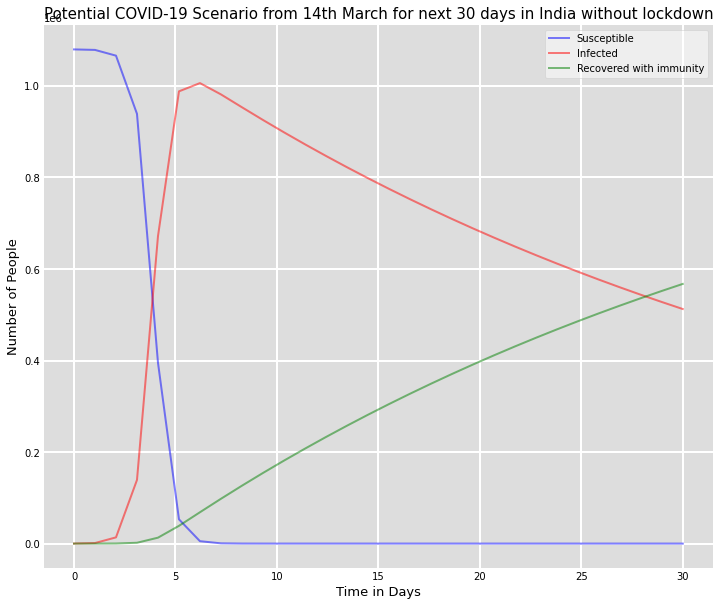

In [ ]:
# Total population, N.
N = 1080000 # considering the a rough estimate of 10 lakhs as population of India who might have been exposed because 135 crore,
            
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 102, 19 # till India crossed 100 cases
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 2.4, 1./35 # considering Beta & Gamma value based on China's & Europe situation
# A grid of time points (in days)
t = np.linspace(0, 30, 30)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w', figsize=(12,10))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time in Days', size=13)
ax.set_ylabel('Number of People', size=13)
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
ax.set_facecolor('#dddddd')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
ax.set_title('Potential COVID-19 Scenario from 14th March for next 30 days in India without lockdown', size=15)
plt.show()

In [ ]:
dbd_tc_india.head(2)

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,2020-01-30,1,1,0,0,0,0
1,2020-01-31,0,1,0,0,0,0


In [ ]:
dbd_tc_param = pd.DataFrame(dbd_tc_india.groupby(['Date'])['Total Confirmed','Total Recovered', 'Total Deceased'].sum().reset_index())
dbd_tc_param['Total Active Cases'] = dbd_tc_param['Total Confirmed'] - dbd_tc_param['Total Recovered'] - dbd_tc_param['Total Deceased']
dbd_tc_param.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-01-30,1,0,0,1
1,2020-01-31,1,0,0,1
2,2020-02-01,1,0,0,1


In [ ]:
dbd_tc_pl = dbd_tc_param[(dbd_tc_param['Date']>'2020-03-01') & (dbd_tc_param['Date']<'2020-03-25')].reset_index(drop=True) # considering pre lockdown period
dbd_tc_pl.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-02,5,3,0,2
1,2020-03-03,6,3,0,3


In [ ]:
dbd_tc_param = dbd_tc_param[dbd_tc_param['Date']>='2020-03-25'].reset_index(drop=True) # considering from lockdown date
dbd_tc_param = dbd_tc_param[:-1]
dbd_tc_param.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-25,657,43,11,603
1,2020-03-26,730,50,16,664


In [ ]:
dbd_tc_param.tail(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
39,2020-05-03,42778,11763,1463,29552
40,2020-05-04,46434,12845,1566,32023


In [ ]:
data = dbd_tc_pl.set_index('Date')['Total Active Cases']
infected = dbd_tc_pl.set_index('Date')['Total Confirmed']
recovered = dbd_tc_pl.set_index('Date')['Total Recovered']

In [ ]:
s_0 = 150000
i_0 = 5
r_0 = 3

In [ ]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [ ]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = list(data.index.values)
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [ ]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.00000001, 2), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('Estimating Beta and Gamma for India during pre-lockdown')
    df.plot(ax=ax)
    print(f"country=India, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")

      fun: 4.688542388362681
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00066755, 0.00070575])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 8
   status: 0
  success: True
        x: array([0.22807272, 0.01422848])
country=India, beta=0.22807272, gamma=0.01422848, r_0:16.02931195


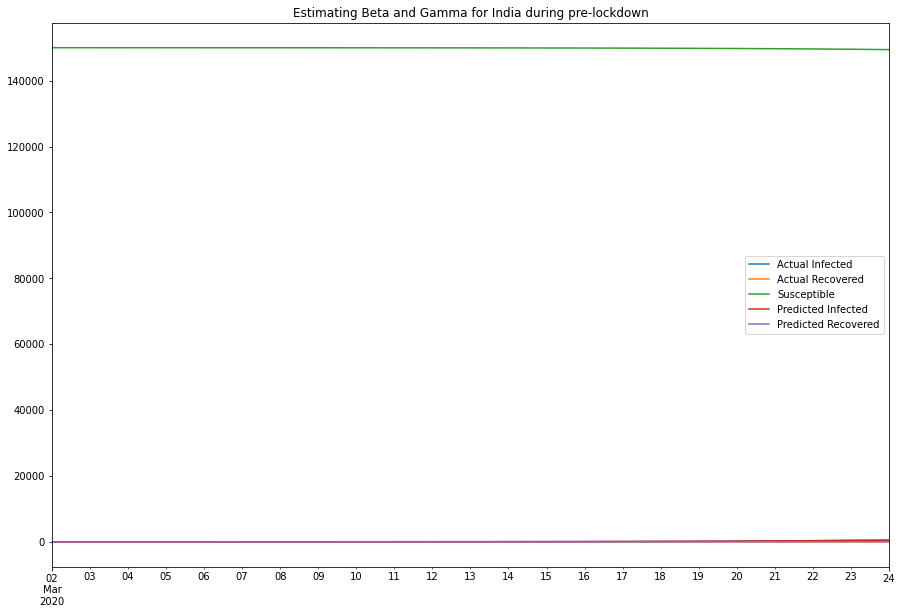

In [ ]:
train(recovered, infected, data)

In [ ]:
dbd_tc_param.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-25,657,43,11,603
1,2020-03-26,730,50,16,664


In [ ]:
dbd_tc_param.tail(2)


,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
39,2020-05-03,42778,11763,1463,29552
40,2020-05-04,46434,12845,1566,32023


In [ ]:
data = dbd_tc_param.set_index('Date')['Total Active Cases']
infected = dbd_tc_param.set_index('Date')['Total Confirmed']
recovered = dbd_tc_param.set_index('Date')['Total Recovered']

In [ ]:
s_0 = 750000 
i_0 = 603
r_0 = 43

In [ ]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [ ]:
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-05-05', periods=90))))) #  months from 5th May

In [ ]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = pres_fut
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [ ]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.000001, 0.5), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('Possible COVID19 India Scenario next 3 months from 5th May, 2021')
    df.plot(ax=ax)
    print(f"country=India, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")

      fun: 634.749610245253
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.07780727, -0.01716671])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 14
   status: 0
  success: True
        x: array([0.14268499, 0.03824572])
country=India, beta=0.14268499, gamma=0.03824572, r_0:3.73074401


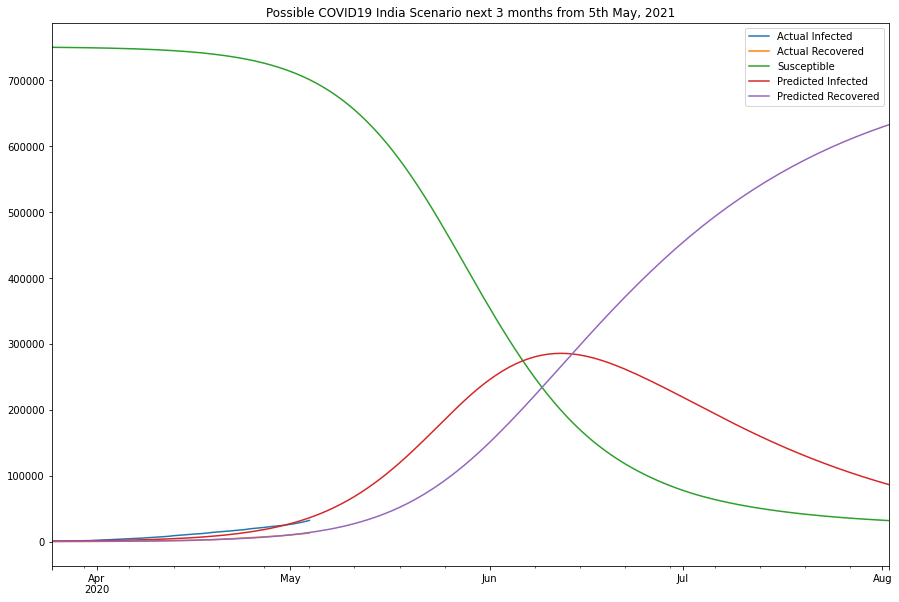

In [ ]:
train(recovered, infected, data)

In [ ]:
d={}
L=list(infected)
for i in L:
  print("Day",L.index(i))
  print("Total",i)
  print("Critical :",i*(0.05))
  print("Severe :",i*(0.15))

Day 0
Total 657
Critical : 32.85
Severe : 98.55
Day 1
Total 730
Critical : 36.5
Severe : 109.5
Day 2
Total 883
Critical : 44.150000000000006
Severe : 132.45
Day 3
Total 1019
Critical : 50.95
Severe : 152.85
Day 4
Total 1139
Critical : 56.95
Severe : 170.85
Day 5
Total 1326
Critical : 66.3
Severe : 198.9
Day 6
Total 1635
Critical : 81.75
Severe : 245.25
Day 7
Total 2059
Critical : 102.95
Severe : 308.84999999999997
Day 8
Total 2545
Critical : 127.25
Severe : 381.75
Day 9
Total 3105
Critical : 155.25
Severe : 465.75
Day 10
Total 3684
Critical : 184.20000000000002
Severe : 552.6
Day 11
Total 4293
Critical : 214.65
Severe : 643.9499999999999
Day 12
Total 4777
Critical : 238.85000000000002
Severe : 716.55
Day 13
Total 5350
Critical : 267.5
Severe : 802.5
Day 14
Total 5915
Critical : 295.75
Severe : 887.25
Day 15
Total 6728
Critical : 336.40000000000003
Severe : 1009.1999999999999
Day 16
Total 7599
Critical : 379.95000000000005
Severe : 1139.85
Day 17
Total 8453
Critical : 422.65000000000003

In [ ]:
d={'Day':[],'Oxygen':[]}
L=list(I)
for i in L:
  print(L.index(i))
  d['Day'].append("Day"+ str(L.index(i)))
  d['Oxygen'].append(i*0.20*0.025)
  print("Day",np.where(I==i))
  print("Oxygen Required :", i*0.20*0.025*1000 , "Litre" )

0
Day (array([0]),)
Oxygen Required : 510.0000000000001 Litre
1
Day (array([1]),)
Oxygen Required : 5922.681525420442 Litre
2
Day (array([2]),)
Oxygen Required : 68039.22951943899 Litre
3
Day (array([3]),)
Oxygen Required : 695539.6541138269 Litre
4
Day (array([4]),)
Oxygen Required : 3358147.5944144763 Litre
5
Day (array([5]),)
Oxygen Required : 4941056.60985416 Litre
6
Day (array([6]),)
Oxygen Required : 5031264.851566704 Litre
7
Day (array([7]),)
Oxygen Required : 4907861.483420765 Litre
8
Day (array([8]),)
Oxygen Required : 4767257.400125224 Litre
9
Day (array([9]),)
Oxygen Required : 4628665.5339081455 Litre
10
Day (array([10]),)
Oxygen Required : 4493888.33692453 Litre
11
Day (array([11]),)
Oxygen Required : 4363011.260845674 Litre
12
Day (array([12]),)
Oxygen Required : 4235942.829728759 Litre
13
Day (array([13]),)
Oxygen Required : 4112574.7662361935 Litre
14
Day (array([14]),)
Oxygen Required : 3992799.6366519267 Litre
15
Day (array([15]),)
Oxygen Required : 3876512.8452136554

In [ ]:
df = pd.DataFrame(d)

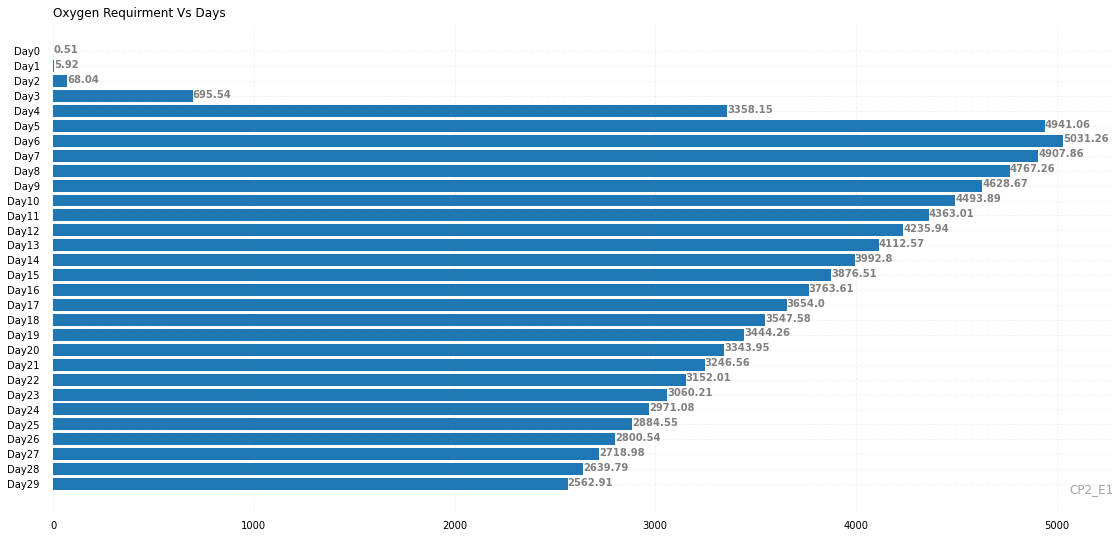

In [ ]:
day = df['Day']
oxygen = df['Oxygen']

# Figure Size
fig, ax = plt.subplots(figsize =(19, 9))

# Horizontal Bar Plot
ax.barh(day, oxygen)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
		linestyle ='-.', linewidth = 0.5,
		alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.2, i.get_y()+0.5,
			str(round((i.get_width()), 2)),
			fontsize = 10, fontweight ='bold',
			color ='grey')

# Add Plot Title
ax.set_title('Oxygen Requirment Vs Days',
			loc ='left', )

# Add Text watermark
fig.text(0.9, 0.15, 'CP2_E1', fontsize = 12,
		color ='grey', ha ='right', va ='bottom',
		alpha = 0.7)

# Show Plot
plt.show()

**Beta and Gamma are estimated in the following way:**
Validation data used is from 2nd Mar to 24th Mar (pre-lockdown period) and 25th Mar to 19th Apr (lockdown period)
Forward prediction of 60 days have been done from 20th April considering parameter values derived during lockdown period
Define y(t) for the SIR model, and then use RMSE as the loss function, and used L-BFGS-B gradient descent optimization to minimise the loss function
add Codeadd Markdown
Pre-Lockdown Period (2nd March-25th March)



Assumptions taken:
An initial population of 150000 could have been potentially exposed to COVID-19 as of 2nd March